In [1]:
from sklearn.tree import DecisionTreeRegressor
from lib.decisiontree import fit_apply
import numpy

from lib.decisiontree_test import sample_X_y_w

# Performance:

sklearn implementation is O(n^2), as soon n is bigger than 10k it starts to be slow:

In [2]:
from time import perf_counter
import matplotlib.pyplot as plt

ns = numpy.logspace(2, 4.5, num=30)
dts = []
for n in ns:
    X, y, w, _ = sample_X_y_w(int(n))
    t = perf_counter()
    reg = DecisionTreeRegressor(max_depth=1, criterion='absolute_error')
    reg.fit(X, y, sample_weight=w).apply(X)
    dts.append(perf_counter() - t)


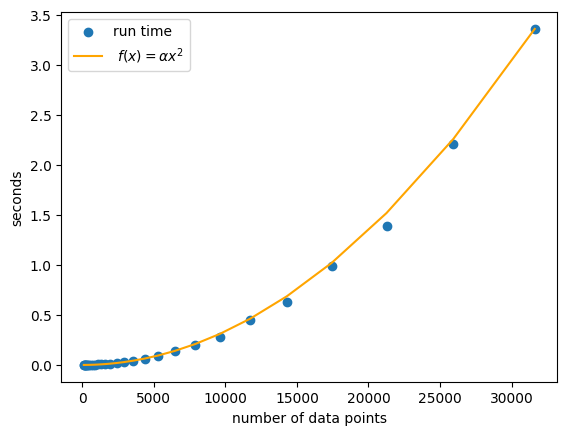

In [3]:
plt.scatter(ns, dts)
alpha = dts[-1] / ns[-1]**2
plt.plot(ns, alpha * ns**2, c='orange')
plt.legend(['run time', r" $f(x) = \alpha x^2$ "])
plt.xlabel('number of data points')
plt.ylabel('seconds');

In [4]:
%%time
X, y, w, _ = sample_X_y_w(50_000)

reg = DecisionTreeRegressor(max_depth=1, criterion='absolute_error')
reg.fit(X, y, sample_weight=w).apply(X)

CPU times: user 8.79 s, sys: 1.98 ms, total: 8.8 s
Wall time: 8.79 s


array([1, 1, 2, ..., 2, 1, 1], shape=(50000,))

My implementation is O(n log n), so it's much fast and can scale to millions of points (even a few billions if you are patient ^^). Though it's still much slower than the MSE based split from sklearn which is in O(n).

In [5]:
%%timeit
leaves = fit_apply(X, y, X_apply=X, sample_weights=w, algo='heaps')

27 ms ± 549 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%time
X, y, w, _ = sample_X_y_w(10**6)
leaves = fit_apply(X, y, X_apply=X, sample_weights=w, algo='heaps')

CPU times: user 792 ms, sys: 50 ms, total: 842 ms
Wall time: 840 ms


In [7]:
%%time
reg = DecisionTreeRegressor(max_depth=1, criterion='squared_error')
reg.fit(X, y, sample_weight=w).apply(X)

CPU times: user 276 ms, sys: 4.01 ms, total: 280 ms
Wall time: 278 ms


array([1, 1, 1, ..., 1, 2, 1], shape=(1000000,))

# Correctness

As one can see by playing with the tests in `lib/decisiontree_test.py`, sklearn's implementation and mine amlost always give the same results. But sometimes mine gives lower absolute error, showing that sklearn's implementation isn't prefectly correct (when sample weights are given).

Note: I can't prove my implementation is prefectly correct (i.e. always returns the minimal-MAE split).

In [8]:
from lib.decisiontree_test import leaves_mae

X = numpy.array([
    [ 2.38, 3.13],
    [-0.87, 0.24],
    [ 3.42, 2.74],
    [ 1.43, 2.57],
    [ 0.86, 0.26]
])
y = numpy.array([0.784, 0.654, 1.125, 2.010, 0.614])
w = numpy.array([0.622, 1.356, 1.206, 0.912, 1.424])

In [9]:
reg = DecisionTreeRegressor(max_depth=1, criterion='absolute_error')
leaves = reg.fit(X, y, sample_weight=w).apply(X)
print(leaves)
leaves_mae(leaves, y, w)

[1 1 2 1 1]


array([1.374492, 0.      ])

In [10]:
leaves = fit_apply(X, y, X_apply=X, sample_weights=w, algo='heaps')
print(leaves)
leaves_mae(leaves, y, w)

[2 1 2 2 1]


array([0.05424 , 1.019222])